In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats, polygraph.likelihood

%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Tutorial on human data

### Read in data

In [2]:
seqs = pd.read_csv('human_seqs.txt')
seqs.head(3)

,Sequence,Group,K562_l2fc,MinGap,K562_lfcSE,K562_prediction,SeqID
0,GCTCGTGAGCCGTCAAGGATGCGCTCACCATCGAGCCACACGTTGG...,FastSeqProp,6.693819,11.262747,0.527668,6.363210,0
1,GTTCGCCCGCGCATGGAGCAACGCTCTCGTTAGGACGCTTTCGTCC...,FastSeqProp,6.488648,10.065946,0.611020,4.845627,1
2,TTTGACAGTTCCCGCCAAAATCGGACCTAGCCGTCTCAAGGCCGAG...,FastSeqProp,5.479217,9.571529,0.361232,5.632198,2


In [3]:
print(seqs.Group.value_counts())

Group
FastSeqProp            2000
Simulated_Annealing    2000
AdaLead                2000
native                 2000
random                 2000
Name: count, dtype: int64


# 1. Sequence composition

## 1.1 GC Content

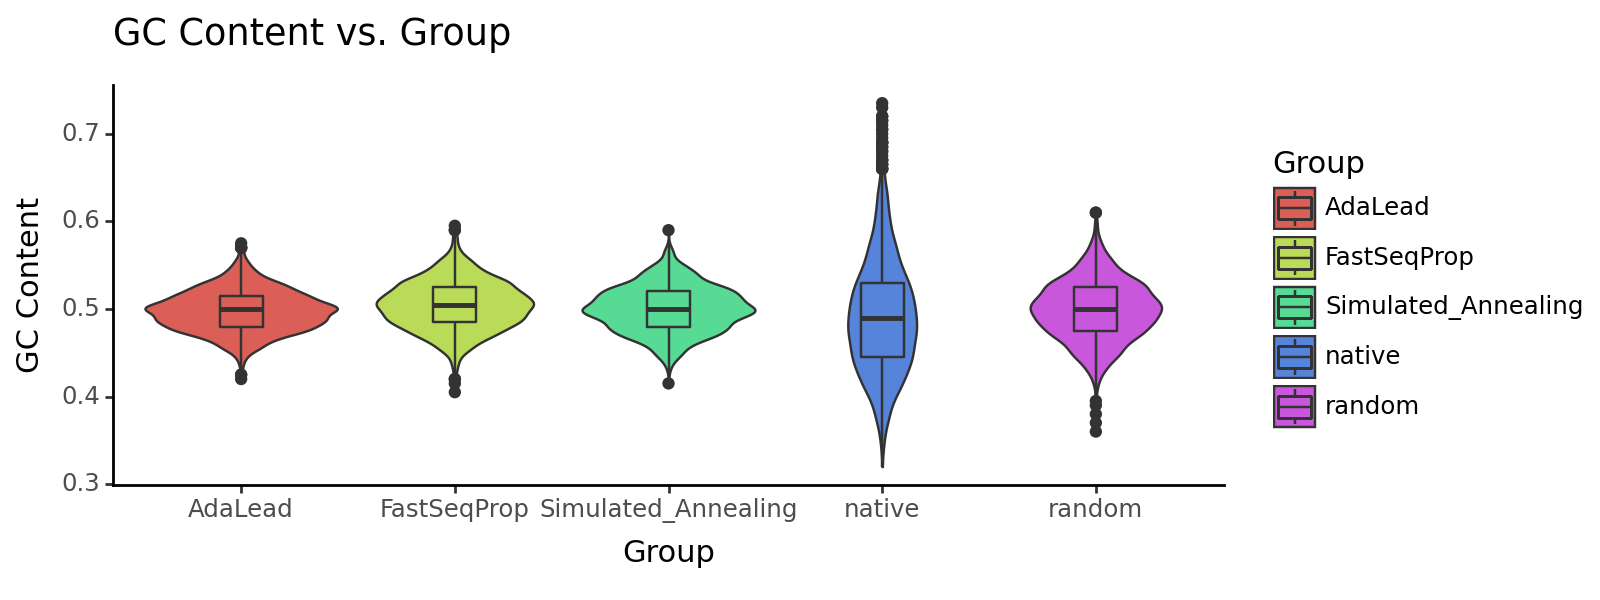

<Figure Size: (800 x 300)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(8, 3))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 3.3631365849739994e-30,
 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
 AdaLead              1.000000e+00  1.339813e-10         8.475353e-02   
 FastSeqProp          1.339813e-10  1.000000e+00         3.600121e-04   
 Simulated_Annealing  8.475353e-02  3.600121e-04         1.000000e+00   
 native               7.994550e-06  1.277959e-30         3.789485e-13   
 random               1.000000e+00  1.057243e-06         1.000000e+00   
 
                            native        random  
 AdaLead              7.994550e-06  1.000000e+00  
 FastSeqProp          1.277959e-30  1.057243e-06  
 Simulated_Annealing  3.789485e-13  1.000000e+00  
 native               1.000000e+00  1.734562e-09  
 random               1.734562e-09  1.000000e+00  }

## 1.2 Length distribution

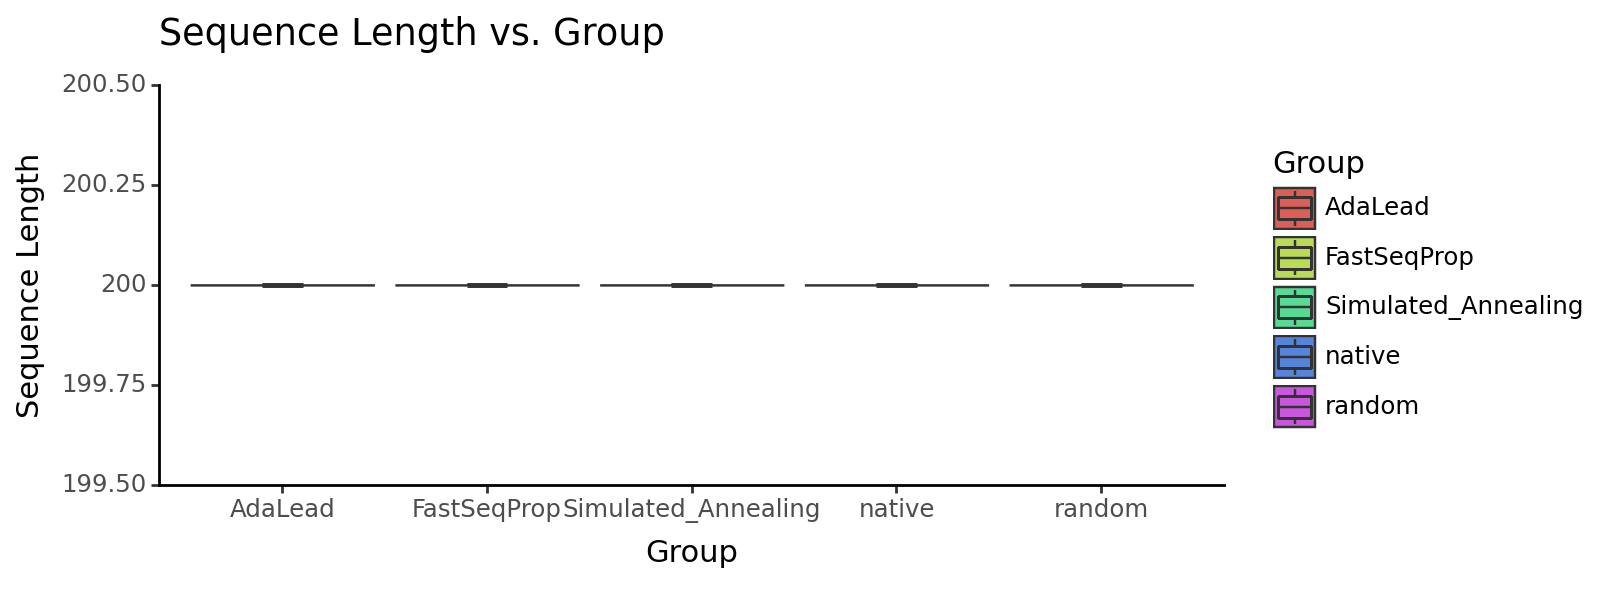

<Figure Size: (800 x 300)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(8, 3))

## 1.3 k-mer content

In [7]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 17.2 s, sys: 519 ms, total: 17.7 s
Wall time: 17.7 s


In [8]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.24987976011050114
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 2min 40s, sys: 17.3 s, total: 2min 57s
Wall time: 43.8 s


In [9]:
ad = polygraph.embedding.one_nn_stats(emb, reference_group='native',
                                      group_col='Group', use_pca=True)

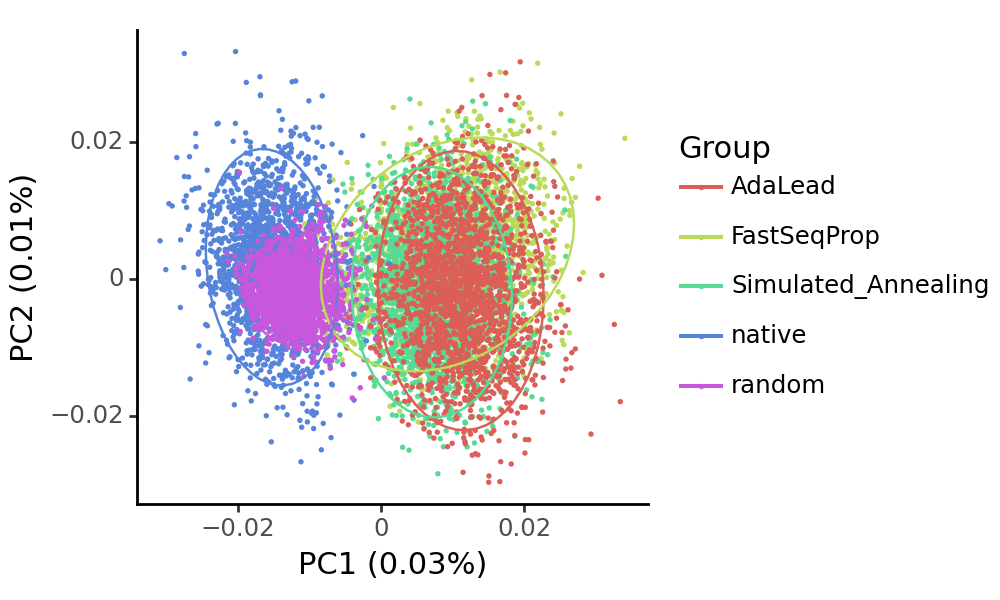

<Figure Size: (500 x 300)>

In [10]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

In [11]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
random                 765
FastSeqProp            722
Simulated_Annealing    717
AdaLead                713
Name: count, dtype: int64

Top Differential k-mers
                    Group  value      score           padj
1024          FastSeqProp  GATAA  38.483311   0.000000e+00
0                 AdaLead  TTATC  36.801987  1.757215e-293
1025          FastSeqProp  TTATC  34.037605  3.170041e-251
2048  Simulated_Annealing  TTATC  33.948215  1.327107e-249
1                 AdaLead  GATAA  33.635479  2.603204e-245
1026          FastSeqProp  ATAAG  33.599346  5.853254e-245
2                 AdaLead  CTTAT  32.068928  4.082288e-223
3                 AdaLead  TGTCA  31.905781  5.683173e-221
1027          FastSeqProp  CTTAT  31.818279  9.259396e-220
4                 AdaLead  TGACA  30.834171  1.870147e-206


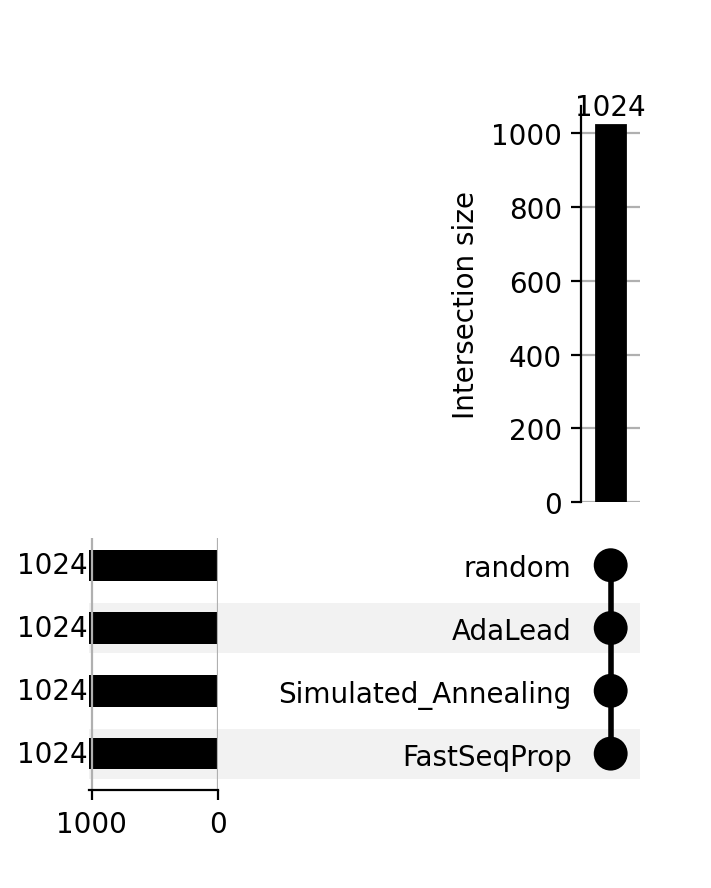

In [12]:
# kmer occurrence
polygraph.visualize.upset_plot(emb[emb.obs.Group!='native'])

In [13]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.43         0.16                 0.40    0.00    0.00
FastSeqProp             0.06         0.69                 0.14    0.00    0.10
Simulated_Annealing     0.25         0.24                 0.46    0.00    0.05
native                  0.00         0.01                 0.00    0.88    0.11
random                  0.00         0.03                 0.00    0.01    0.96

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0045     0.879   0.0   0.0
Simulated_Annealing      0.0035     0.879   0.0   0.0
AdaLead                  0.0010     0.879   0.0   0.0
random                   0.0120     0.879   0.0   0.0


p-values for distance to closest reference
{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  native  \
AdaLead              1.000000e+00  7.519483e-34         1.230345e-41     0.0   
FastSeqProp          7.519483e-34  1.000000e+00         1.000000e+00     0.0   
Simulated_Annealing  1.230345e-41  1.000000e+00         1.000000e+00     0.0   
native               0.000000e+00  0.000000e+00         0.000000e+00     1.0   
random               0.000000e+00  0.000000e+00         0.000000e+00     1.0   

                     random  
AdaLead                 0.0  
FastSeqProp             0.0  
Simulated_Annealing     0.0  
native                  1.0  
random                  1.0  }


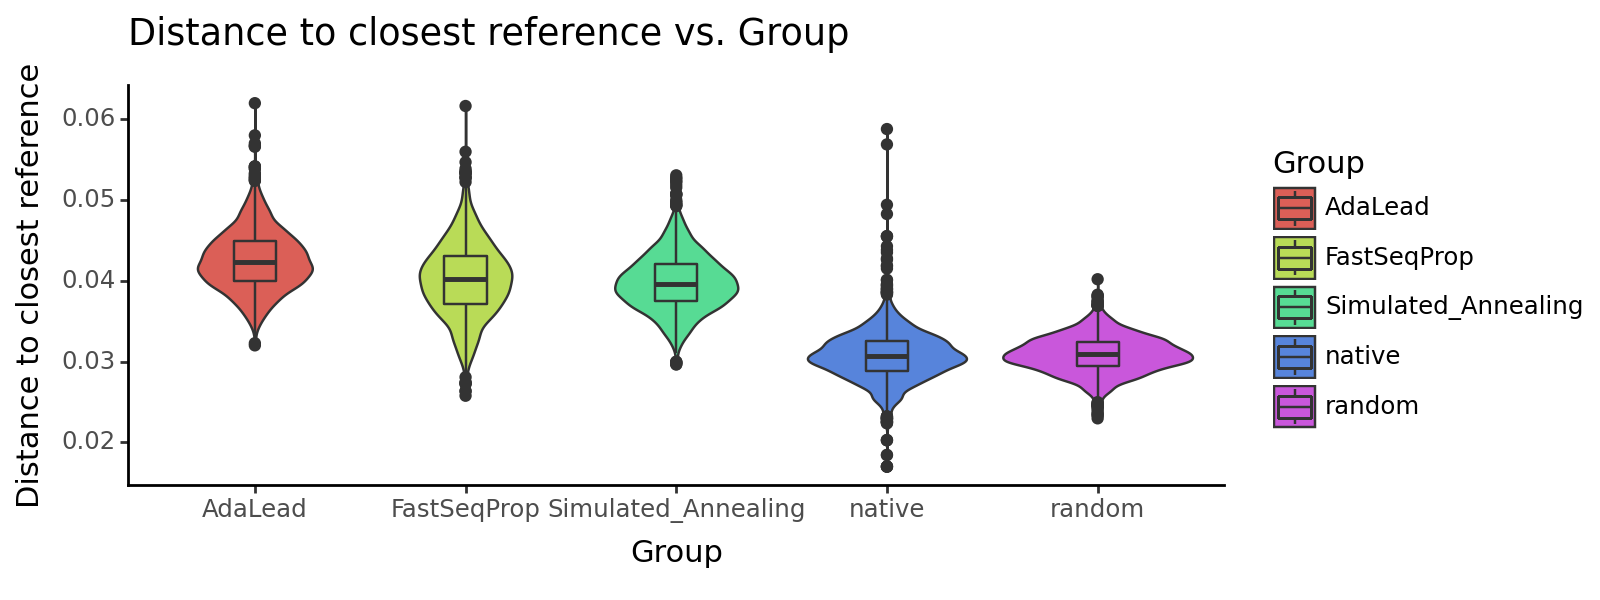

<Figure Size: (800 x 300)>

In [14]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                            AdaLead    FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  9.384288e-186         1.890244e-46   
FastSeqProp          9.384288e-186   1.000000e+00         9.106645e-48   
Simulated_Annealing   1.890244e-46   9.106645e-48         1.000000e+00   
native               3.060118e-216   2.066646e-01         9.638958e-64   
random                0.000000e+00   0.000000e+00         0.000000e+00   

                            native  random  
AdaLead              3.060118e-216     0.0  
FastSeqProp           2.066646e-01     0.0  
Simulated_Annealing   9.638958e-64     0.0  
native                1.000000e+00     0.0  
random                0.000000e+00     1.0  }


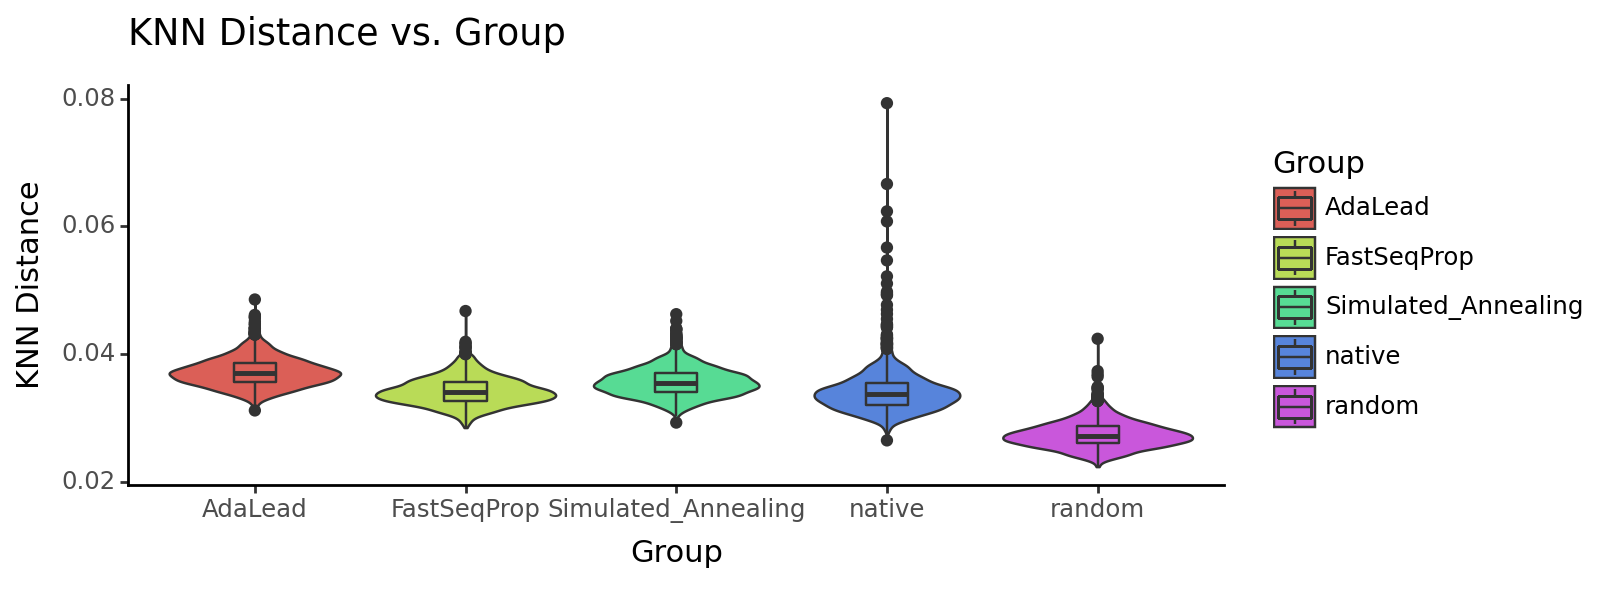

<Figure Size: (800 x 300)>

In [15]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

## 2. Motif content

In [16]:
jaspar = polygraph.input.load_jaspar()
len(jaspar)

841

For the sake of speed, we will analyze only the first 100 motifs in JASPAR.

In [17]:
%%time 
counts = polygraph.motifs.motif_frequencies(seqs, jaspar[:100], num_workers=8, normalize=True)

Processing motifs
Scanning
Assembling count matrix
CPU times: user 2.33 s, sys: 8.31 s, total: 10.6 s
Wall time: 4min 40s


In [18]:
meta = pd.DataFrame(counts.columns, columns=['MotifID'])
counts = counts.loc[:, ~counts.columns.isna()]

In [19]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native')

Creating AnnData object
PCA
Fraction of variance explained:  [0.08 0.06 0.04 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Fraction of total variance explained:  0.7625890089343609
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 2min 35s, sys: 13.5 s, total: 2min 48s
Wall time: 26.7 s


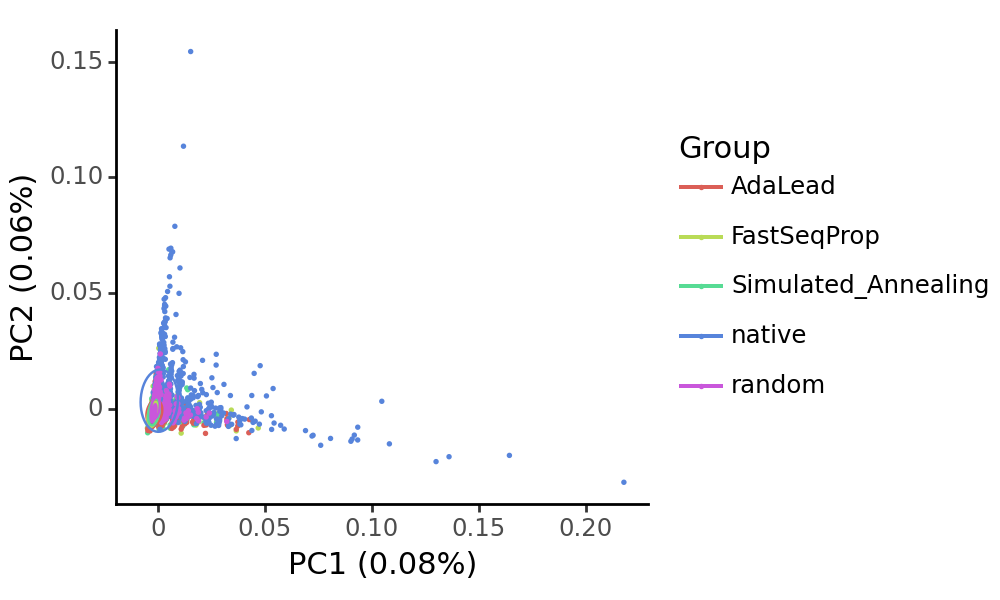

<Figure Size: (500 x 300)>

In [20]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

In [21]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential motifs compared to reference
Group
AdaLead                74
random                 72
FastSeqProp            67
Simulated_Annealing    67
Name: count, dtype: int64

Top Differential motifs
                   Group        value      score           padj
100          FastSeqProp   TAL1::TCF3  32.838314  1.672626e-234
101          FastSeqProp  GATA1::TAL1  26.902180  1.035482e-157
0                AdaLead  GATA1::TAL1  22.337414  1.600426e-108
200  Simulated_Annealing  GATA1::TAL1  22.112494  2.396598e-106
1                AdaLead   EWSR1-FLI1 -16.823551   8.201321e-62
201  Simulated_Annealing   EWSR1-FLI1 -15.629089   2.306731e-53
102          FastSeqProp   EWSR1-FLI1 -15.279043   3.515946e-51
202  Simulated_Annealing   TAL1::TCF3  15.087597   6.514395e-50
300               random   EWSR1-FLI1 -14.332437   1.372205e-44
103          FastSeqProp        FOSL2 -14.197481   2.374131e-44


In [22]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

Fraction of sequences by 1-NN group
one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.34         0.25                 0.33    0.02    0.06
FastSeqProp             0.18         0.51                 0.24    0.02    0.05
Simulated_Annealing     0.28         0.31                 0.32    0.02    0.07
native                  0.16         0.14                 0.18    0.37    0.16
random                  0.15         0.18                 0.21    0.06    0.39

p-values for proportion of sequences with native nearest neighbor
                     group_prop  ref_prop           pval           padj
Group                                                                  
FastSeqProp              0.0175      0.37  1.284253e-206  5.137012e-206
Simulated_Annealing      0.0200      0.37  3.903109e-201  7.806218e-201
AdaLead                  0.0230      0.37  6.826719e-195

p-values for distance to closest reference
{'Kruskal': 5.048794589607954e-132, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead              1.000000e+00  1.000000e+00         1.000000e+00   
FastSeqProp          1.000000e+00  1.000000e+00         1.000000e+00   
Simulated_Annealing  1.000000e+00  1.000000e+00         1.000000e+00   
native               2.644958e-81  8.183012e-83         1.654164e-88   
random               1.000000e+00  1.000000e+00         1.000000e+00   

                           native        random  
AdaLead              2.644958e-81  1.000000e+00  
FastSeqProp          8.183012e-83  1.000000e+00  
Simulated_Annealing  1.654164e-88  1.000000e+00  
native               1.000000e+00  6.057854e-86  
random               6.057854e-86  1.000000e+00  }


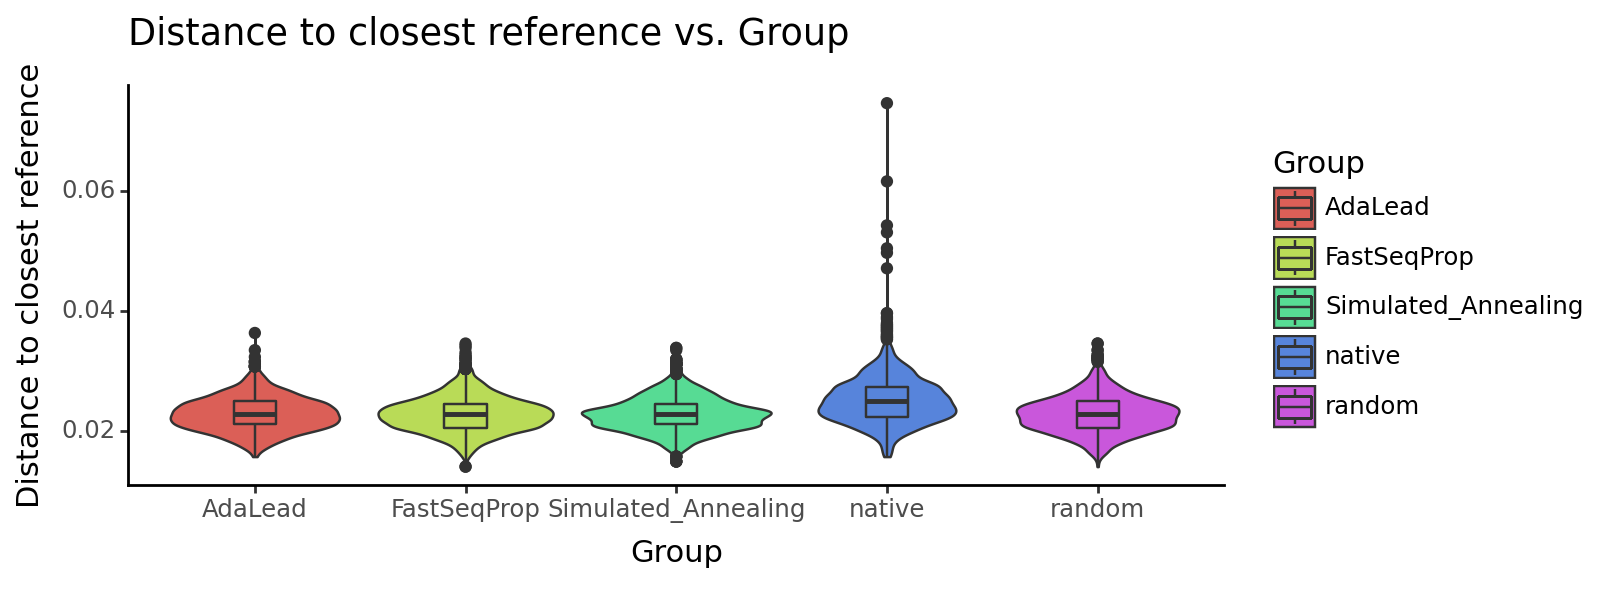

<Figure Size: (800 x 300)>

In [23]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

p-values for KNN diversity
{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead              1.000000e+00  3.669738e-02         1.000000e+00   
FastSeqProp          3.669738e-02  1.000000e+00         3.257044e-03   
Simulated_Annealing  1.000000e+00  3.257044e-03         1.000000e+00   
native               0.000000e+00  0.000000e+00         0.000000e+00   
random               1.605233e-10  5.247805e-21         1.454381e-08   

                            native         random  
AdaLead               0.000000e+00   1.605233e-10  
FastSeqProp           0.000000e+00   5.247805e-21  
Simulated_Annealing   0.000000e+00   1.454381e-08  
native                1.000000e+00  1.039390e-248  
random               1.039390e-248   1.000000e+00  }


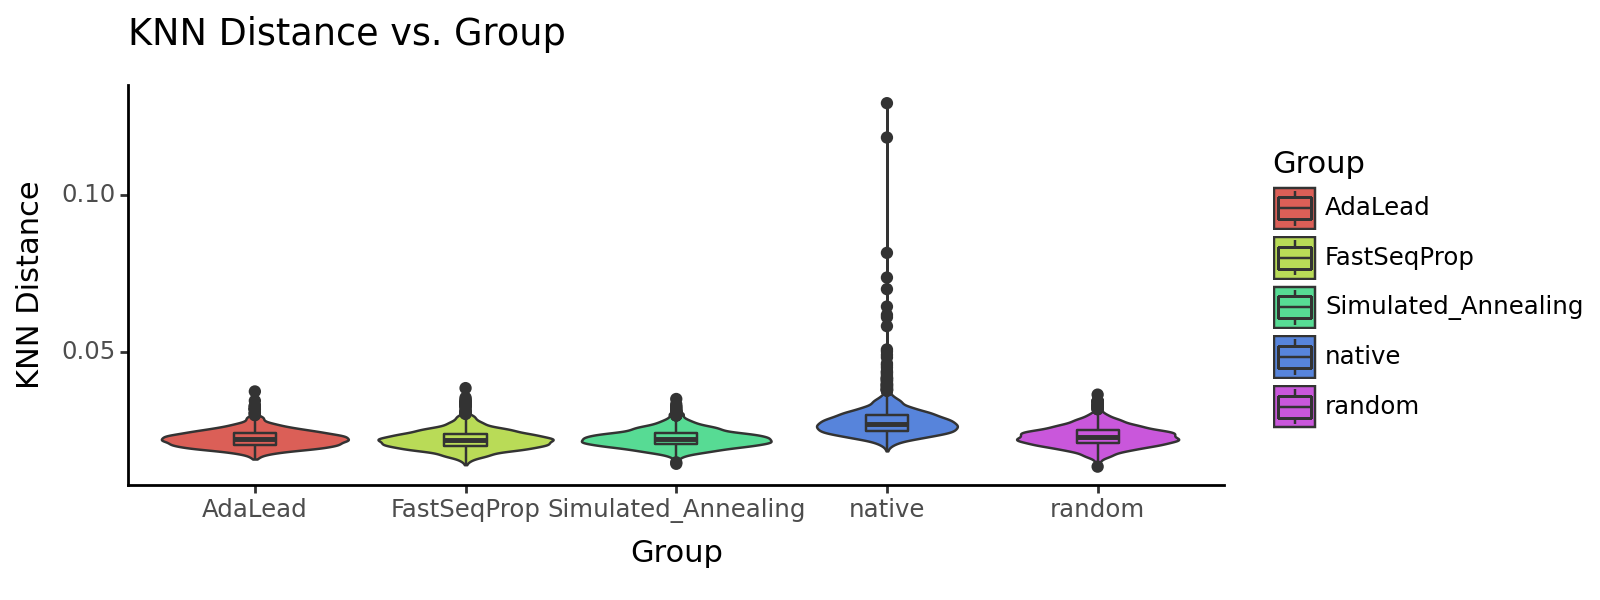

<Figure Size: (800 x 300)>

In [24]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

## 2.2 Motif combinations

We will identify co-occurring combinations of motifs using the count matrix. This function can take a long time, so for speed we use here only the first 500 rows of the count matrix.

In [30]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(counts.iloc[:500, :], seqs, reference_group='native')

Listing motif combinations
Making count matrix
Filtering
Selected 1965 combinations
Significance testing
CPU times: user 27 s, sys: 29.7 ms, total: 27 s
Wall time: 27 s


In [31]:
motif_combinations.sort_values('padj').head(10)

,Group,group_prop,ref_prop,pval,padj,combination
0,FastSeqProp,0.1525,0.0,1.077658e-97,8.470392e-94,"(GATA1::TAL1, TAL1::TCF3)"
4,FastSeqProp,0.0620,0.0,1.314635e-38,5.166515e-35,"(GATA1::TAL1, Mecom)"
8,FastSeqProp,0.0595,0.0,4.929134e-37,1.291433e-33,"(TAL1::TCF3, Mecom)"
12,FastSeqProp,0.0500,0.0,4.434262e-31,8.713326e-28,"(TAL1::TCF3, Hand1::Tcf3)"
16,FastSeqProp,0.0495,0.0,9.099452e-31,1.430434e-27,"(TAL1::TCF3, SREBF1)"
20,FastSeqProp,0.0475,0.0,1.609239e-29,2.108104e-26,"(GATA1::TAL1, SREBF1)"
28,FastSeqProp,0.0465,0.0,6.756515e-29,6.638276e-26,"(Creb3l2, TAL1::TCF3)"
24,FastSeqProp,0.0465,0.0,6.756515e-29,6.638276e-26,"(GATA1::TAL1, Rhox11)"
32,FastSeqProp,0.0450,0.0,5.800989e-28,5.066197e-25,"(Creb3l2, GATA1::TAL1)"
36,FastSeqProp,0.0435,0.0,4.968611e-27,3.905328e-24,"(STAT1, GATA1::TAL1)"


In [32]:
# Are there any significant motif combinations where neither individual motif
# is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [33]:
sig_combs[sig_combs.Group=='FastSeqProp']

,Group,group_prop,ref_prop,pval,padj,combination
524,FastSeqProp,0.0200,0.0,1.493815e-12,8.697321e-11,"(DUX4, Nr2e3)"
952,FastSeqProp,0.0155,0.0,8.283712e-10,2.724267e-08,"(NFIC::TLX1, Nr2e3)"
1036,FastSeqProp,0.0145,0.0,3.363276e-09,9.407598e-08,"(Esrrg, Nr2e3)"
1540,FastSeqProp,0.0115,0.0,2.237255e-07,4.227121e-06,"(NR1H2::RXRA, Nr2e3)"
1560,FastSeqProp,0.0115,0.0,2.237255e-07,4.227121e-06,"(PBX1, Nr2e3)"
1984,FastSeqProp,0.0105,0.0,9.046531e-07,1.399719e-05,"(FOXD1, Nr2e3)"
2172,FastSeqProp,0.0100,0.0,1.818444e-06,2.464305e-05,"(Esrrg, NR1H2::RXRA)"
2468,FastSeqProp,0.0095,0.0,3.654329e-06,4.338826e-05,"(FOXD1, DUX4)"
2628,FastSeqProp,0.0095,0.0,3.654329e-06,4.338826e-05,"(NFIC::TLX1, DUX4)"
3044,FastSeqProp,0.0085,0.0,1.474663e-05,1.411797e-04,"(DUX4, NR1H2::RXRA)"


## 2.3 Motif positions

In [34]:
# Select the TF motif most enriched in synthetic sequences
emb.uns['DE_test'].sort_values('padj').head()

,Group,value,score,padj
100,FastSeqProp,TAL1::TCF3,32.838314,1.672626e-234
101,FastSeqProp,GATA1::TAL1,26.902180,1.035482e-157
0,AdaLead,GATA1::TAL1,22.337414,1.600426e-108
200,Simulated_Annealing,GATA1::TAL1,22.112494,2.396598e-106
1,AdaLead,EWSR1-FLI1,-16.823551,8.201321e-62


In [43]:
%%time
sites = polygraph.motifs.scan_seqs(seqs, [m for m in jaspar if m.name=="GATA1::TAL1"], num_workers=8)
sites.head()

Processing motifs
Scanning
CPU times: user 3.35 s, sys: 508 ms, total: 3.86 s
Wall time: 10.3 s


,MotifID,score,start,end,SeqID,Group
0,GATA1::TAL1,10.043582,87.0,105.0,0,FastSeqProp
1,GATA1::TAL1,16.572465,153.0,171.0,0,FastSeqProp
2,GATA1::TAL1,6.896053,118.0,136.0,2,FastSeqProp
3,GATA1::TAL1,1.913889,143.0,161.0,3,FastSeqProp
4,GATA1::TAL1,14.945974,150.0,168.0,3,FastSeqProp


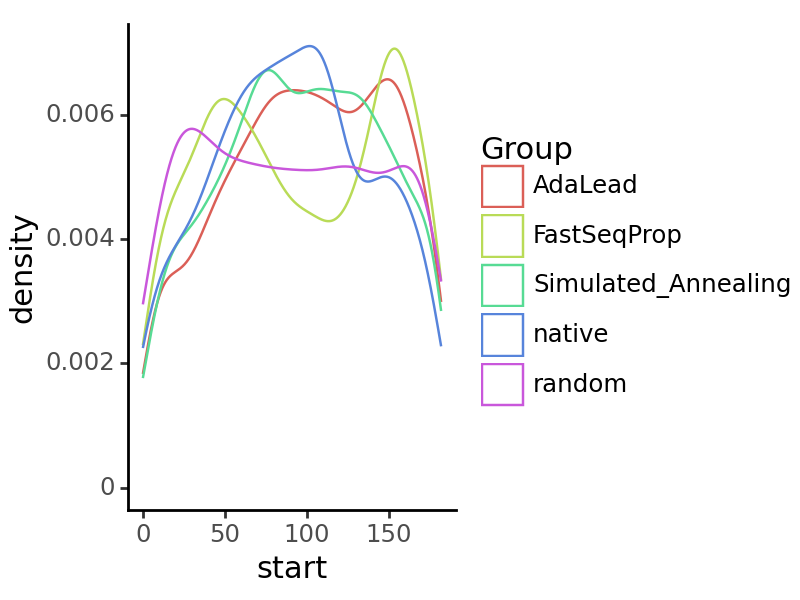

<Figure Size: (400 x 300)>

In [44]:
polygraph.visualize.densityplot(sites, value_col='start') + p9.theme(figure_size=(4, 3))

In [45]:
polygraph.stats.kruskal_dunn(sites, val_col='start')

{'Kruskal': 0.0010027093521252075,
 'Dunn':                       AdaLead  FastSeqProp  Simulated_Annealing    native  \
 AdaLead              1.000000     0.051938             0.363718  0.003496   
 FastSeqProp          0.051938     1.000000             1.000000  1.000000   
 Simulated_Annealing  0.363718     1.000000             1.000000  0.446862   
 native               0.003496     1.000000             0.446862  1.000000   
 random               0.049621     1.000000             0.999803  1.000000   
 
                        random  
 AdaLead              0.049621  
 FastSeqProp          1.000000  
 Simulated_Annealing  0.999803  
 native               1.000000  
 random               1.000000  }

## 2.4 NMF

In [46]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native', n_components=10)

/opt/conda/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.


CPU times: user 1min 33s, sys: 4.55 s, total: 1min 37s
Wall time: 1.01 s


In [47]:
p[p.padj < .001]

,group,pval,padj,factor
0,FastSeqProp,2.770116e-35,4.817593e-35,factor_0
1,Simulated_Annealing,4.890850e-14,5.928303e-14,factor_0
2,AdaLead,3.876976e-28,5.964578e-28,factor_0
3,random,7.037225e-19,9.382967e-19,factor_0
0,FastSeqProp,3.223188e-275,1.289275e-273,factor_1
1,Simulated_Annealing,1.148862e-75,2.872156e-75,factor_1
2,AdaLead,1.445014e-66,2.890028e-66,factor_1
0,FastSeqProp,1.104926e-18,1.425711e-18,factor_2
1,Simulated_Annealing,1.856935e-16,2.321169e-16,factor_2
2,AdaLead,3.320579e-06,3.689532e-06,factor_2


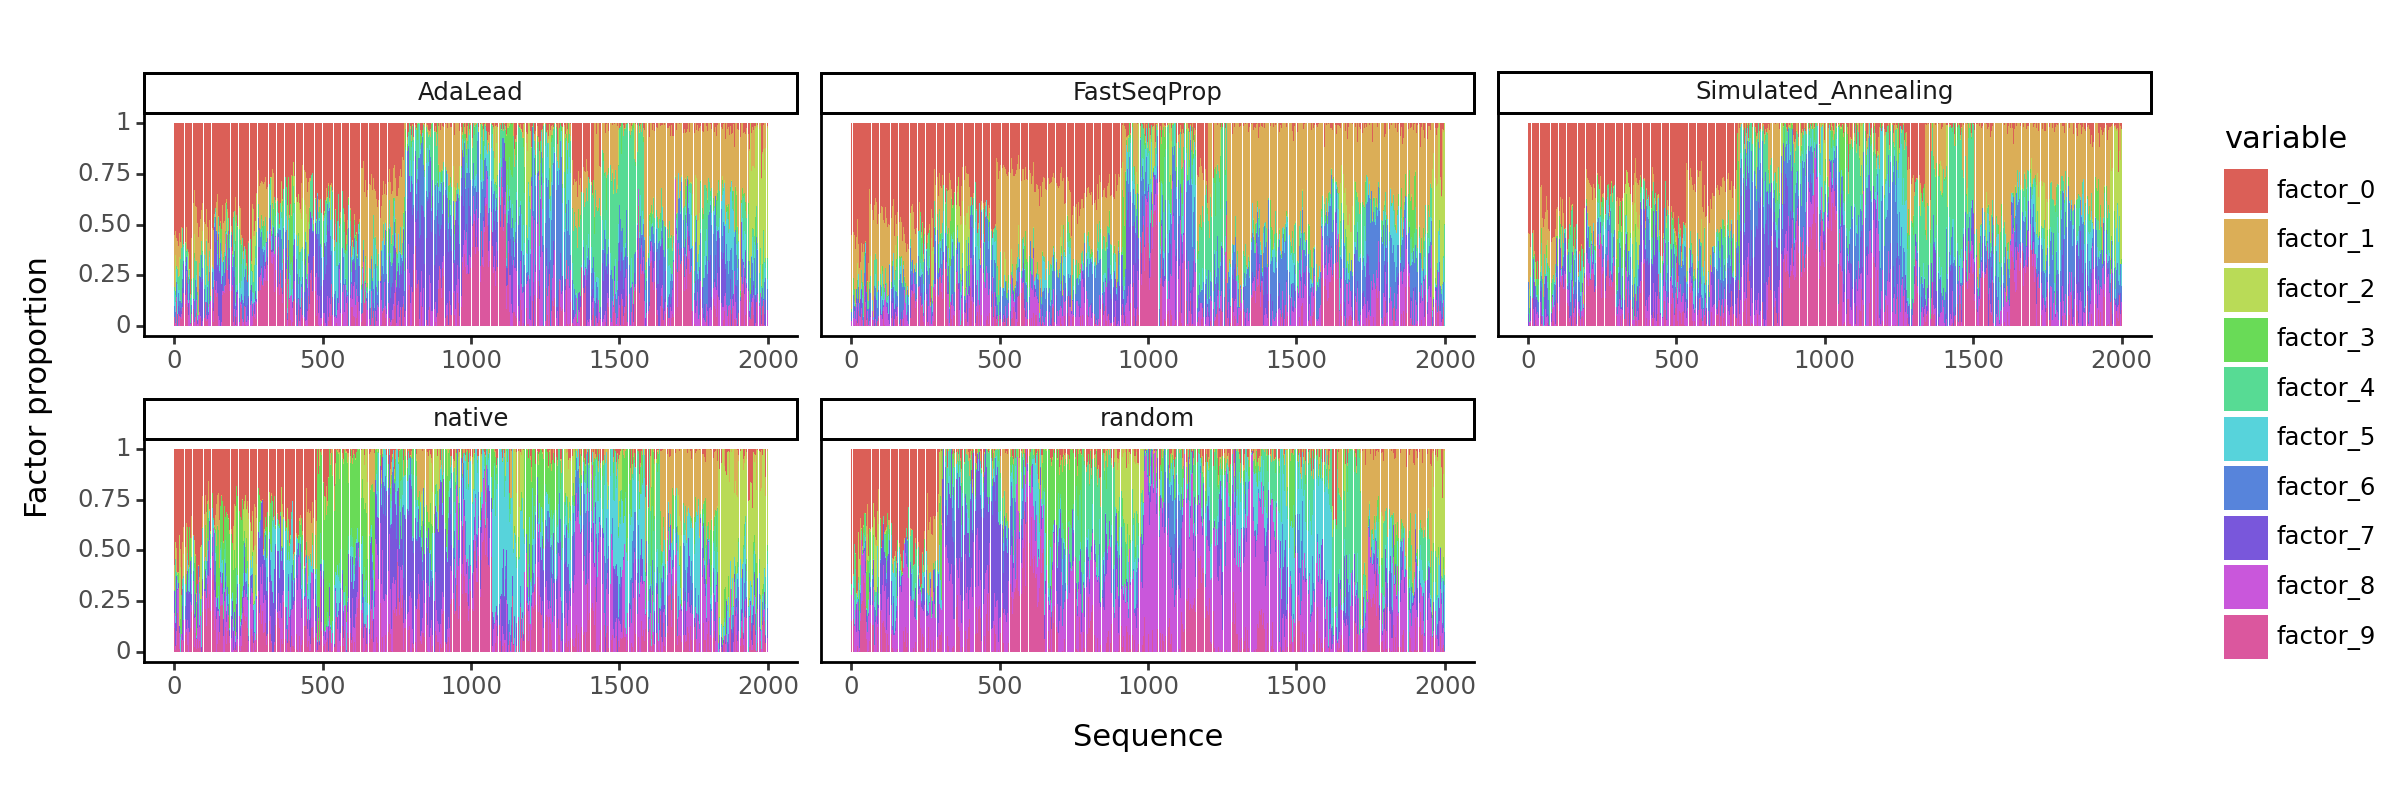

<Figure Size: (1200 x 400)>

In [48]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

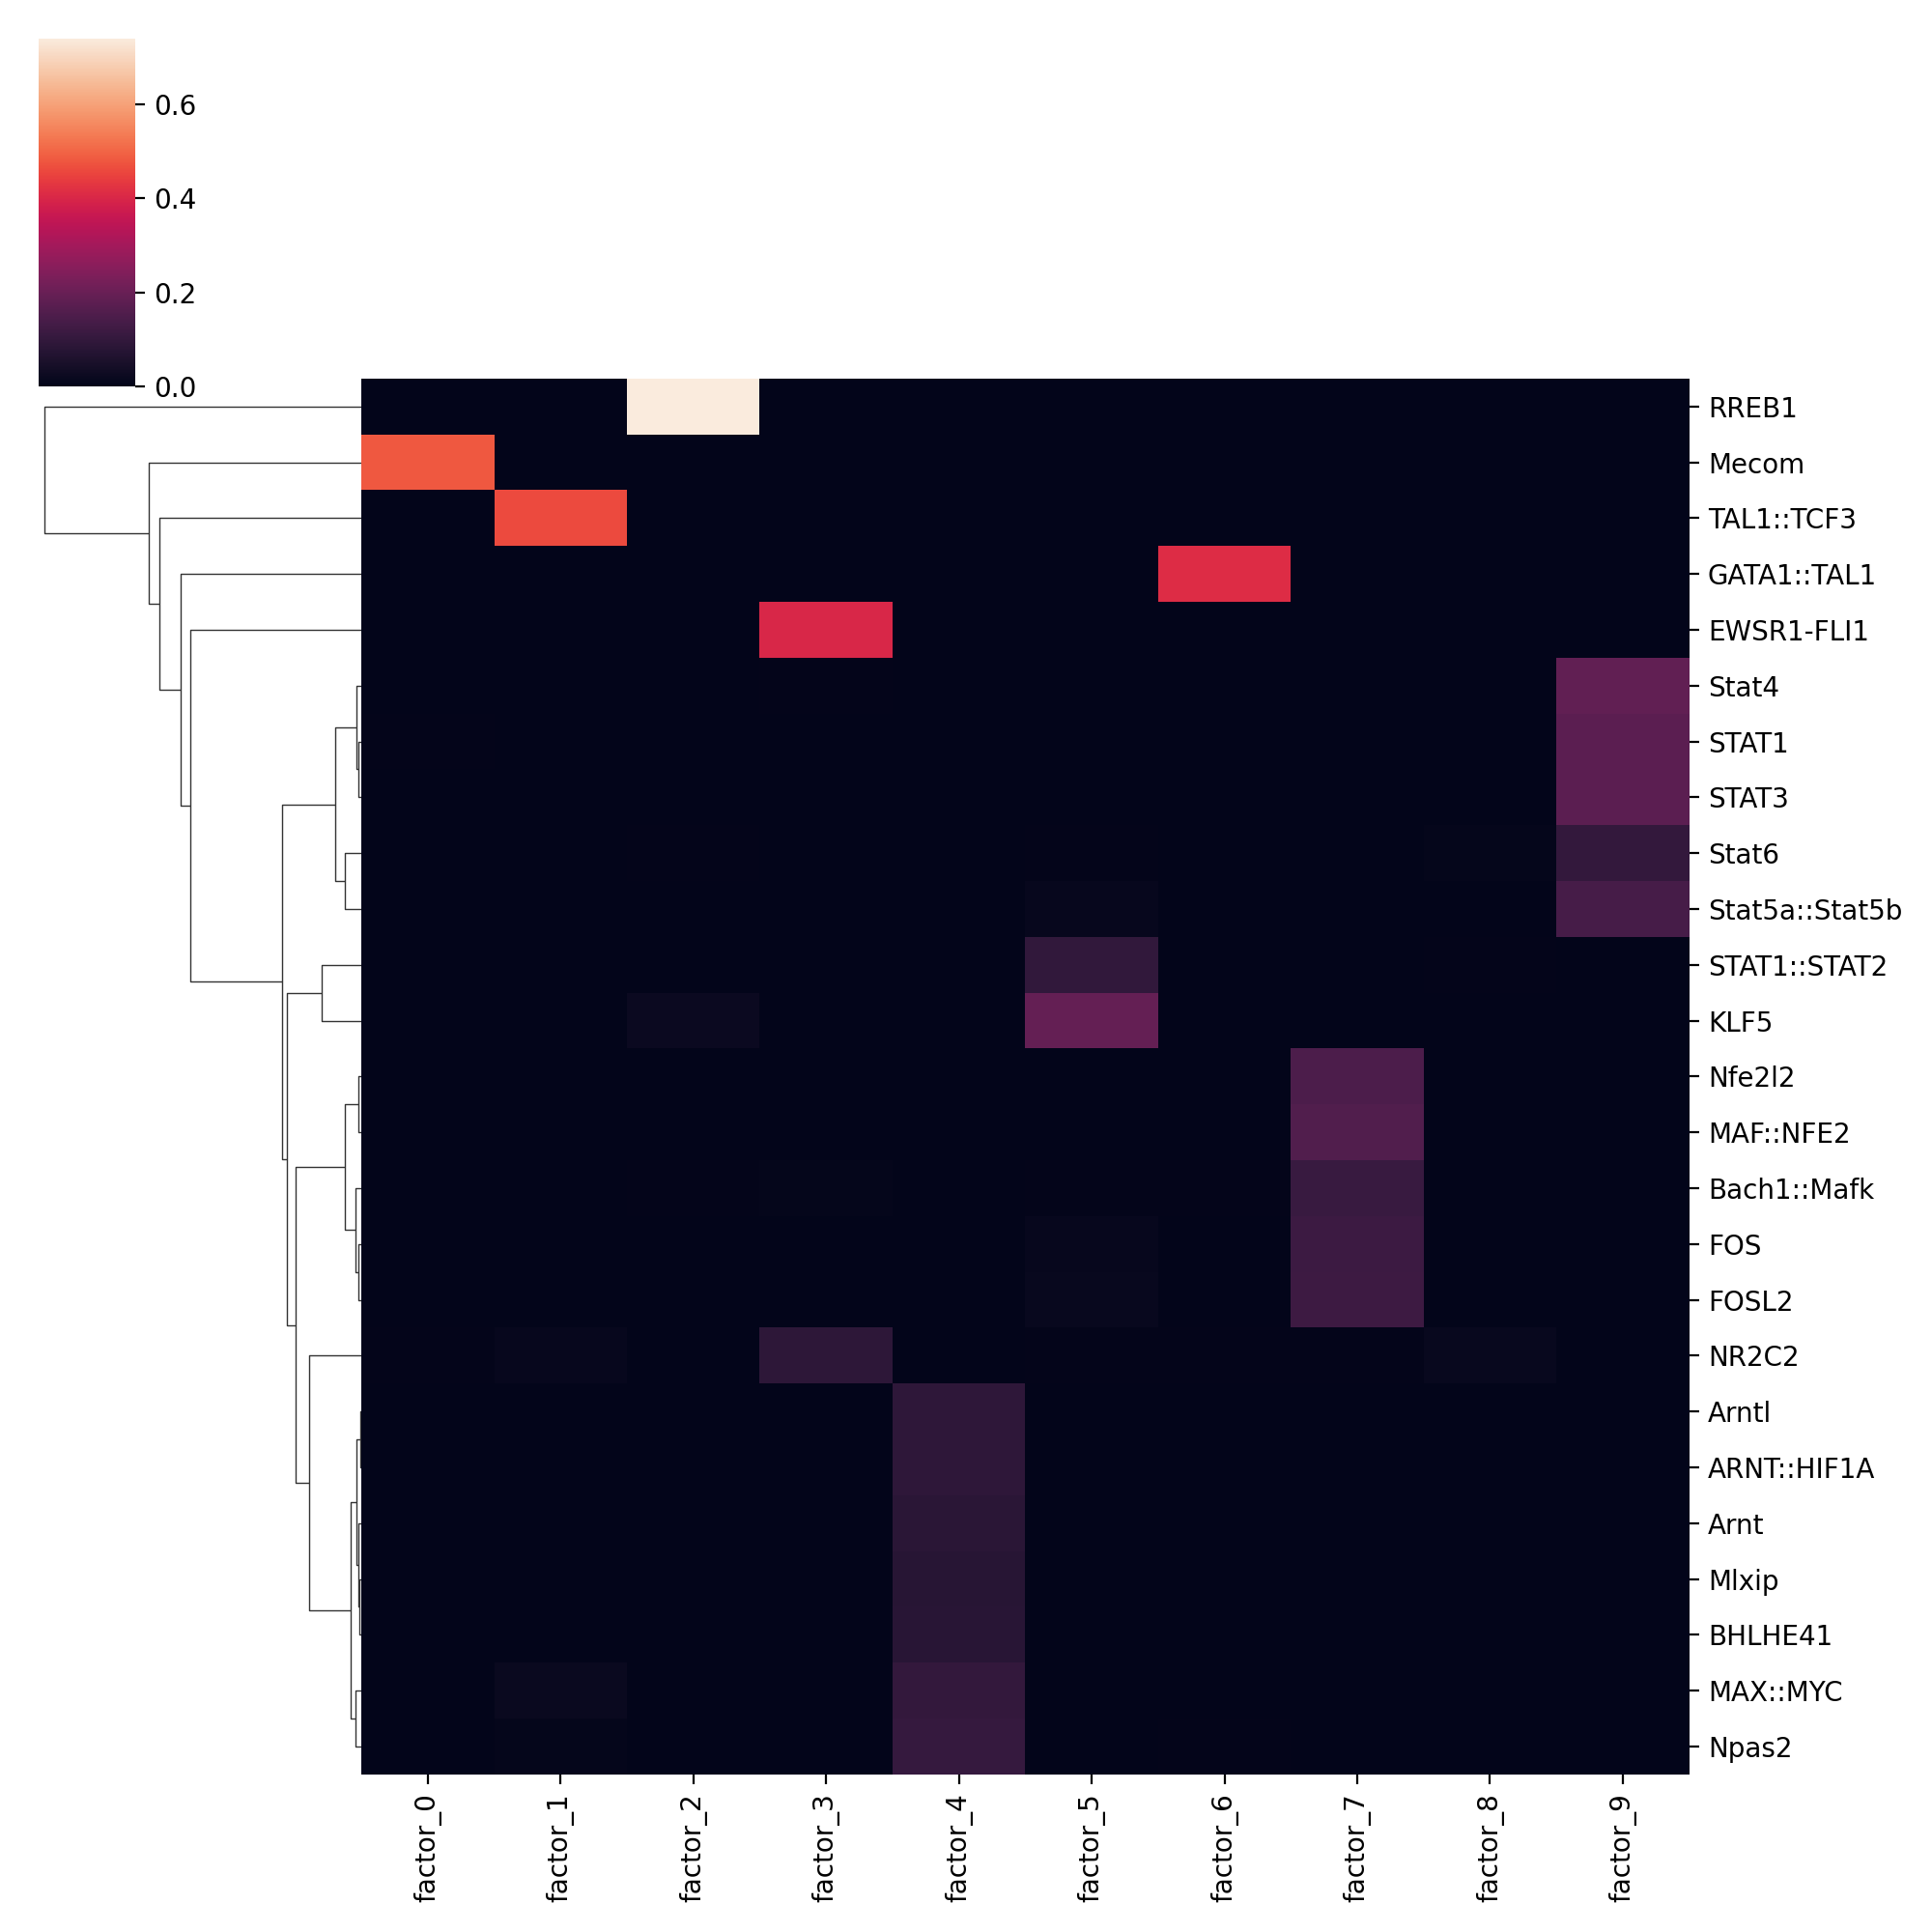

In [49]:
polygraph.visualize.plot_factors_nmf(H, n_features=25)

# 3. Model predictions

### Load model trained on catlas data

In [50]:
!wget https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth

--2023-12-01 18:07:49--  https://zenodo.org/records/10214625/files/catlas-enformer-release-model_2.pth
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288449775 (275M) [application/octet-stream]
Saving to: ‘catlas-enformer-release-model_2.pth’

catlas-enformer-rel 100%[===================>] 275.09M  18.8MB/s    in 16s     

2023-12-01 18:08:06 (17.0 MB/s) - ‘catlas-enformer-release-model_2.pth’ saved [288449775/288449775]



In [51]:
import torch
model = torch.load('catlas-enformer-release-model_2.pth')

### Get model predictions

In [52]:
preds = polygraph.models.predict(model, seqs, batch_size=512)
preds.shape

Padding all sequences to length 200


(10000, 203)

### Model embeddings

In [53]:
embeddings = polygraph.models.sequential_embed(seqs.Sequence.tolist(), model, drop_last_layers=4, swapaxes=True)
embeddings.shape

(10000, 1536)

In [54]:
%%time
emb = polygraph.embedding.embedding_analysis(embeddings, seqs, reference_group='native')

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.74 0.07 0.03 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9680153
UMAP
Differential feature abundance


/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: overflow encountered in expm1
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in divide
/opt/conda/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value 

1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 3min 23s, sys: 14.6 s, total: 3min 37s
Wall time: 54.5 s


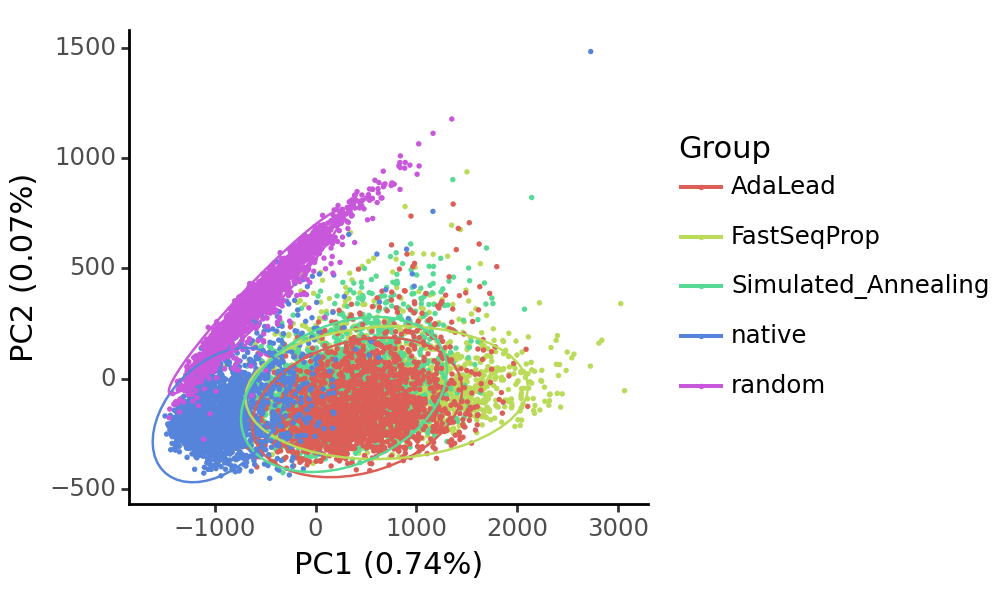

<Figure Size: (500 x 300)>

In [55]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(5, 3))

In [56]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])

one_nn_group         AdaLead  FastSeqProp  Simulated_Annealing  native  random
Group                                                                         
AdaLead                 0.57         0.10                 0.32    0.00    0.00
FastSeqProp             0.12         0.65                 0.22    0.00    0.01
Simulated_Annealing     0.33         0.18                 0.49    0.00    0.00
native                  0.00         0.01                 0.00    0.94    0.04
random                  0.00         0.01                 0.00    0.01    0.98
                     group_prop  ref_prop  pval  padj
Group                                                
FastSeqProp              0.0010    0.9375   0.0   0.0
Simulated_Annealing      0.0010    0.9375   0.0   0.0
AdaLead                  0.0000    0.9375   0.0   0.0
random                   0.0115    0.9375   0.0   0.0


{'Kruskal': 0.0, 'Dunn':                           AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead              1.000000e+00  1.786902e-08         1.232315e-09   
FastSeqProp          1.786902e-08  1.000000e+00         1.374500e-34   
Simulated_Annealing  1.232315e-09  1.374500e-34         1.000000e+00   
native               0.000000e+00  0.000000e+00         0.000000e+00   
random               0.000000e+00  0.000000e+00        1.084725e-241   

                           native         random  
AdaLead              0.000000e+00   0.000000e+00  
FastSeqProp          0.000000e+00   0.000000e+00  
Simulated_Annealing  0.000000e+00  1.084725e-241  
native               1.000000e+00   1.172607e-55  
random               1.172607e-55   1.000000e+00  }


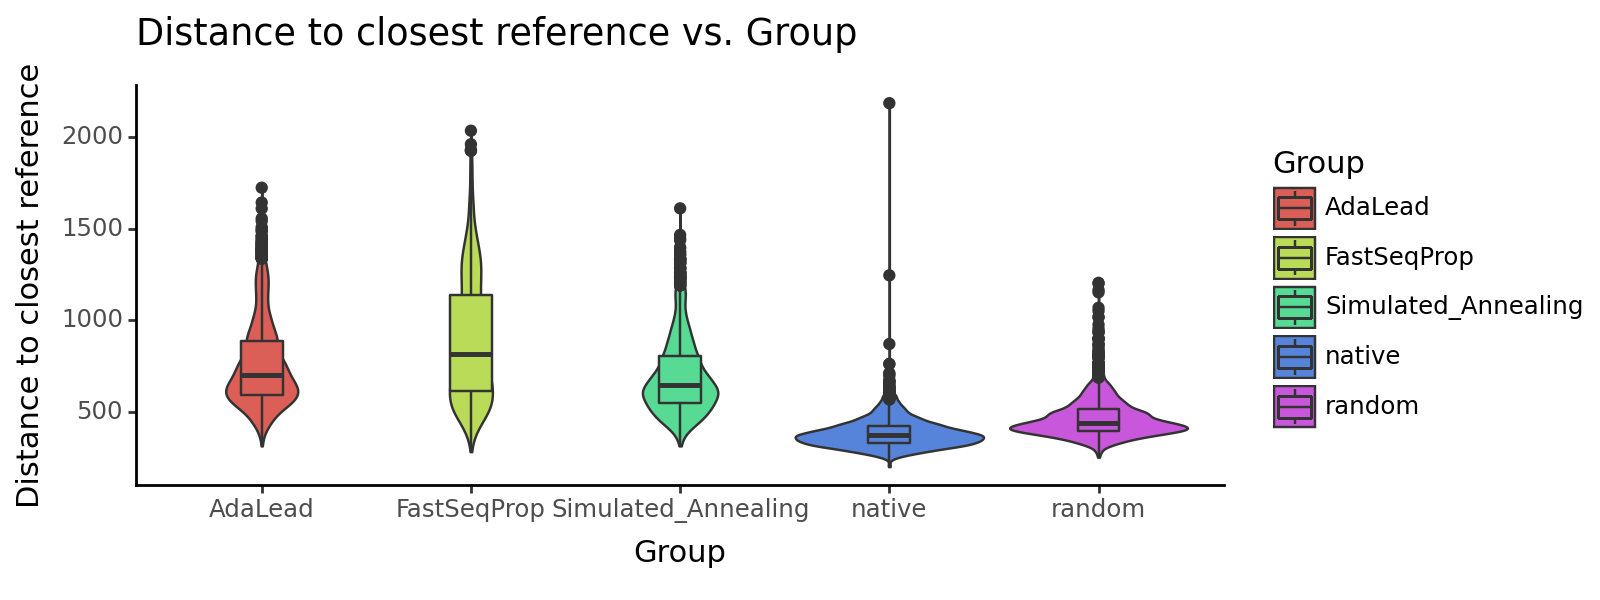

<Figure Size: (800 x 300)>

In [57]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(8, 3))

{'Kruskal': 0.0, 'Dunn':                            AdaLead   FastSeqProp  Simulated_Annealing  \
AdaLead               1.000000e+00  1.756541e-11         4.555330e-01   
FastSeqProp           1.756541e-11  1.000000e+00         1.402829e-18   
Simulated_Annealing   4.555330e-01  1.402829e-18         1.000000e+00   
native                2.324677e-25  3.561196e-03         1.582926e-35   
random               1.965546e-274  0.000000e+00        1.753594e-244   

                           native         random  
AdaLead              2.324677e-25  1.965546e-274  
FastSeqProp          3.561196e-03   0.000000e+00  
Simulated_Annealing  1.582926e-35  1.753594e-244  
native               1.000000e+00   0.000000e+00  
random               0.000000e+00   1.000000e+00  }


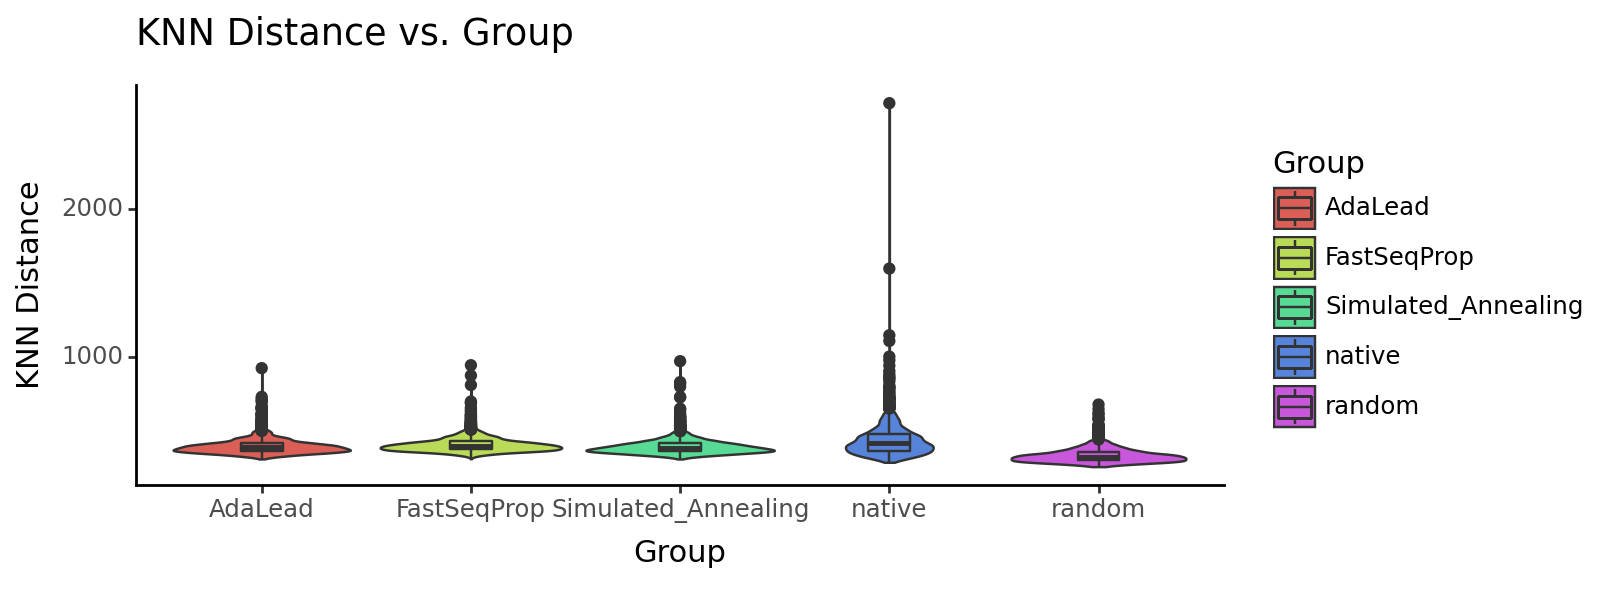

<Figure Size: (800 x 300)>

In [58]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(8, 3))

# 4. Language model likelihood calculation

In [59]:
# Substitute '/hyena-dna' with the path to your cloned hyena-dna repository
# See https://github.com/HazyResearch/hyena-dna for instructions to clone and install hyenadna
model = polygraph.likelihood.load_hyenadna(hyena_path='/hyena-dna')

--2023-12-01 18:10:13--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/config.json
Resolving huggingface.co (huggingface.co)... 108.138.246.71, 108.138.246.67, 108.138.246.85, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 535 [text/plain]
Saving to: ‘./config.json’

     0K                                                       100%  120M=0s

2023-12-01 18:10:13 (120 MB/s) - ‘./config.json’ saved [535/535]

--2023-12-01 18:10:13--  https://huggingface.co/LongSafari/hyenadna-small-32k-seqlen/resolve/main/weights.ckpt
Resolving huggingface.co (huggingface.co)... 108.138.246.71, 108.138.246.79, 108.138.246.67, ...
Connecting to huggingface.co (huggingface.co)|108.138.246.71|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/23/bd/23bd011121e3699e6bfa5aa57274ac119b996f4c129b31145d6fffeaa6229b55/33558e085d0545

Loading config
Building model
Loading weights


In [60]:
seqs['Sequences'] = seqs['Sequence'] 
log_likelihood = polygraph.likelihood.compute_likelihood(
    seqs, model, num_workers=8, device=0)
seqs['log_likelihood'] = log_likelihood

In [61]:
seqs.groupby('Group')['log_likelihood'].describe()

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
AdaLead,2000.0,-287.427739,4.166199,-301.399511,-290.440336,-287.500691,-284.739613,-271.471718
FastSeqProp,2000.0,-288.439634,3.852729,-300.431080,-291.064262,-288.596733,-285.971724,-273.312976
Simulated_Annealing,2000.0,-288.626438,3.998796,-303.749637,-291.459621,-288.637038,-286.006086,-273.902052
native,2000.0,-258.660185,24.457794,-287.292461,-269.619886,-265.177277,-259.493411,-89.584358
random,2000.0,-288.893092,3.984205,-302.661377,-291.682892,-288.991896,-286.428944,-268.550478


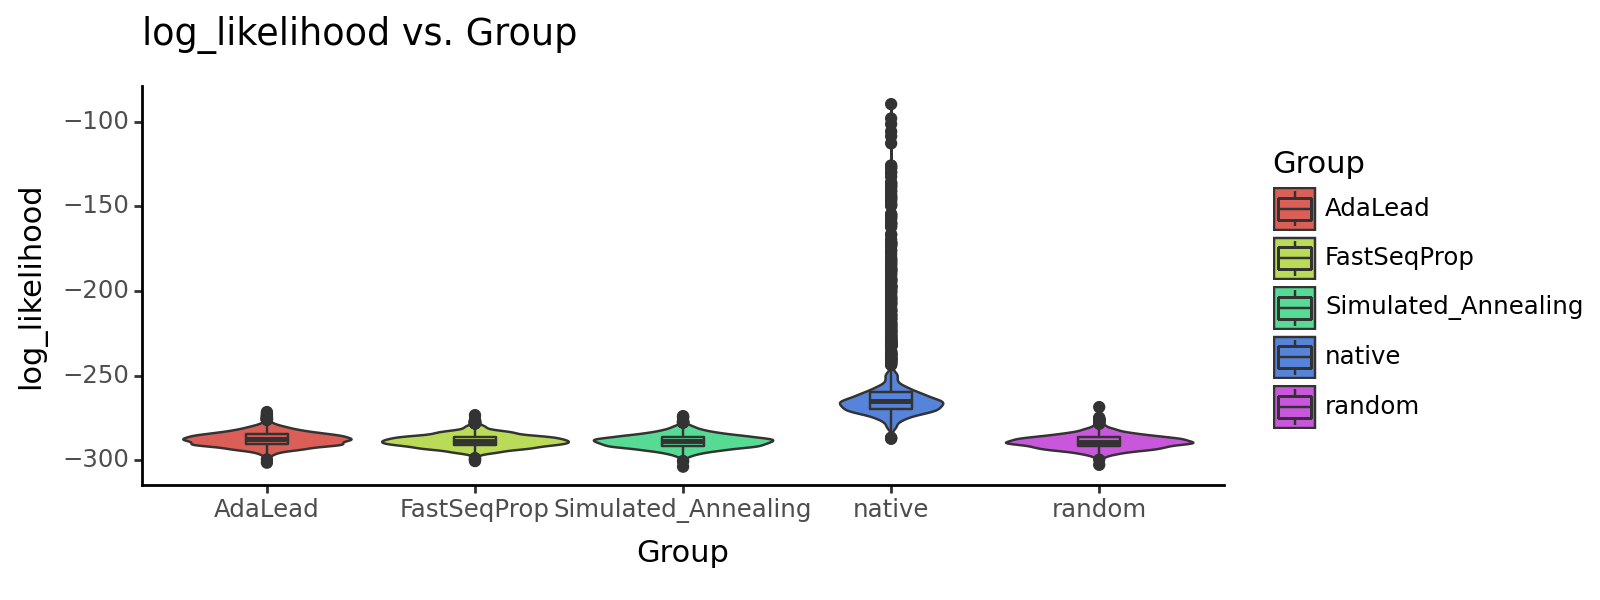

<Figure Size: (800 x 300)>

In [62]:
polygraph.visualize.boxplot(seqs, group_col="Group", value_col="log_likelihood") + p9.theme(figure_size=(8, 3))